<a href="https://colab.research.google.com/github/JMFerret/colab/blob/main/2_stocks_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [128]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
import pandas as pd

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [129]:
# Manually input number of stocks
NUMBER_OF_STOCKS = 2

STOCK_TICKERS = ["AAPL", "AMZN"]

vol = 0.8

VOLATILITY_ARRAY =[vol, vol]

correl = 0.1

COEF_MATRIX = np.array([
    [1.0, correl],
    [correl, 1.0],
])

stock_data = {}
stock_data['AAPL'] = {'Vol': vol, 'Weight': 0.5}
stock_data['AMZN'] = {'Vol': vol, 'Weight': 0.5}


## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [130]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(COEF_MATRIX)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.  0.1]
 [0.1 1. ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [131]:
T = 252                                                  # Number of simulated days
stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = VOLATILITY_ARRAY                      # Volatility (annual, 0.01=1%)
r = 0.001                                                # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [132]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array[n,t-1]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array[n,t] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

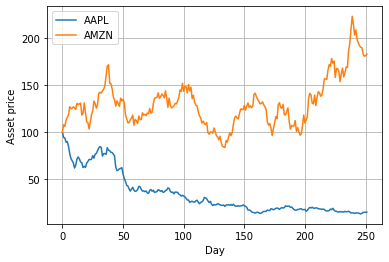

In [133]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [134]:
weights = {} 
for stock in STOCK_TICKERS:
  weights[stock] = 1 / NUMBER_OF_STOCKS

index = []
for t in range(T):
  index.append(0)
  for i, stock in enumerate(STOCK_TICKERS):
    index[t] += weights[stock] * stock_price_array[i][t]


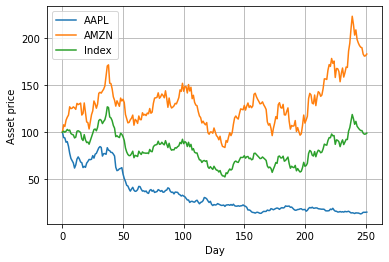

In [135]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))
    
ax.plot(array_day_plot, index, label = 'Index')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [167]:
def run_simul(threshold):

  df = pd.DataFrame(stock_price_array)
  df = df.transpose()
  df = df.rename(columns={0: "AAPL", 1: "AMZN"})
  df["Index"] = index
  cols = ["AAPL", "AMZN", "Index"]
  for col in cols:
    df[col + '_returns'] = df[col].pct_change(1)

  df['Prtf_val_s'] = 0.0
  df['Prtf_val_e'] = 0.0
  df['Prtf_Index_diff'] = 0.0

  df.at[0, 'Prtf_val_s'] +=  np.nan
  df.at[0, 'Prtf_val_e'] = 100

  for stock in stock_data.keys():
    df[stock + '_wt_s'] = 0.0
    df[stock + '_wt_e'] = 0.0
    df[stock + '_val_s'] = 0.0
    df[stock + '_val_e'] = 0.0
    df[stock + '_nos_s'] = 0.0
    df[stock + '_nos_e'] = 0.0
    df.at[0, stock + '_wt_s'] = np.nan
    df.at[0, stock + '_val_s'] = np.nan
    df.at[0, stock + '_nos_s'] = np.nan
    df.at[0, stock + '_wt_e'] = stock_data[stock]['Weight']
    df.at[0, stock + '_val_e'] = df['Prtf_val_e'].iloc[0] * df[stock + '_wt_e'].iloc[0]
    df.at[0, stock + '_nos_e'] = df[stock + '_val_e'].iloc[0] / df[stock].iloc[0]
    

  for t in range(1, T):
    df.at[t, 'Prtf_val_s'] = df['Prtf_val_e'].iloc[t-1]

    rebalance = False
    for stock in stock_data.keys():
      # threshold = stock_data[stock]['Vol'] / sqrt(252)
      # threshold = 1000
      if abs(df[stock + '_returns'].iloc[t-1]) > threshold:
        rebalance = True  # rebalance if one of the stocks moved more than its daily vol

    for stock in stock_data.keys():
      if rebalance:  # if rebalance
        df.at[t, stock + '_wt_s'] = stock_data[stock]['Weight']  # start weight = initial weight
        df.at[t, stock + '_val_s'] = df['Prtf_val_s'].iloc[t] * df[stock + '_wt_s'].iloc[t]  # start stock value = start prtf value * start weight
        df.at[t, stock + '_nos_s'] = df[stock + '_val_s'].iloc[t] / df[stock].iloc[t-1]  # start number of shares = start stock value / prev close
      
      else:  # no rebalance
        df.at[t, stock + '_wt_s'] = df[stock + '_wt_e'].iloc[t-1] # start weight = prev end weight
        df.at[t, stock + '_val_s'] = df[stock + '_val_e'].iloc[t-1] # start stock val = prev end stock val
        df.at[t, stock + '_nos_s'] = df[stock + '_nos_e'].iloc[t-1] # start nos = prev end nos

      df.at[t, stock + '_nos_e'] = df[stock + '_nos_s'].iloc[t]  # end nos = start nos
      df.at[t, stock + '_val_e'] = df[stock + '_nos_e'].iloc[t] * df[stock].iloc[t] # end stock val = end nos * close

      df.at[t, 'Prtf_val_e'] += df[stock + '_val_e'].iloc[t]  # end prtf val = sum end stock val

    for stock in stock_data.keys():
      df.at[t, stock + '_wt_e'] = df[stock + '_val_e'].iloc[t] / df['Prtf_val_e'].iloc[t]  # end weight = end stock val / end prtf val

    df.at[t,'Prtf_Index_diff'] = df['Prtf_val_e'].iloc[t] - df['Index'].iloc[t]

  return df

thresh_range = [x/100 for x in range(30)]
for threshold in thresh_range:
  df = run_simul(threshold)
  prtf_return = 100 * (df['Prtf_val_e'].iloc[T-1] / df['Prtf_val_e'].iloc[0] - 1)
  index_return = 100 * (df['Index'].iloc[T-1] / df['Index'].iloc[0] - 1)
  alpha = prtf_return - index_return
  print(f"Treshold: {threshold}, Prt: {round(prtf_return, 2)}, Index: {round(index_return, 2)}, Alpha: {round(alpha, 2)}")
# df


Treshold: 0.0, Prt: -39.82, Index: -0.9, Alpha: -38.92
Treshold: 0.01, Prt: -39.8, Index: -0.9, Alpha: -38.9
Treshold: 0.02, Prt: -39.87, Index: -0.9, Alpha: -38.97
Treshold: 0.03, Prt: -40.01, Index: -0.9, Alpha: -39.11
Treshold: 0.04, Prt: -40.33, Index: -0.9, Alpha: -39.43
Treshold: 0.05, Prt: -40.3, Index: -0.9, Alpha: -39.4
Treshold: 0.06, Prt: -38.08, Index: -0.9, Alpha: -37.18
Treshold: 0.07, Prt: -36.45, Index: -0.9, Alpha: -35.55
Treshold: 0.08, Prt: -35.88, Index: -0.9, Alpha: -34.98
Treshold: 0.09, Prt: -34.5, Index: -0.9, Alpha: -33.6
Treshold: 0.1, Prt: -38.5, Index: -0.9, Alpha: -37.6
Treshold: 0.11, Prt: -36.73, Index: -0.9, Alpha: -35.83
Treshold: 0.12, Prt: -37.32, Index: -0.9, Alpha: -36.42
Treshold: 0.13, Prt: -29.31, Index: -0.9, Alpha: -28.41
Treshold: 0.14, Prt: -29.4, Index: -0.9, Alpha: -28.5
Treshold: 0.15, Prt: -30.5, Index: -0.9, Alpha: -29.6
Treshold: 0.16, Prt: -30.5, Index: -0.9, Alpha: -29.6
Treshold: 0.17, Prt: -0.9, Index: -0.9, Alpha: 0.0
Treshold: 0.1

In [137]:
# Check realised vol
for stock in stock_data.keys():
  print(f"{stock} Realised Vol: {100 * round(df[stock + '_returns'].dropna().std() * np.sqrt(T), 2)}")
  print(f"{stock} Input Vol: {100 * round(stock_data[stock]['Vol'], 2)}")
  print(f"{stock} Input Daily Vol: {100 * round(stock_data[stock]['Vol'] / sqrt(252), 2)}")

AAPL Realised Vol: 76.0
AAPL Input Vol: 80.0
AAPL Input Daily Vol: 5.0
AMZN Realised Vol: 81.0
AMZN Input Vol: 80.0
AMZN Input Daily Vol: 5.0


In [151]:
for t in range(1, T):
    print(t)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


In [139]:
stock_data['AAPL']['Vol'] / sqrt(252)

0.05039526306789696

In [140]:
data = {'toto':[1,2], 'tata':[3,4]}
dft = pd.DataFrame(data)
for i in range(len(dft)):
  print(dft['tata'].iloc[i])

3
4
